# PA1.2 - Word Embeddings

### Introduction

In this notebook, you will learn how to train your own word embeddings using LSTMs, then explore some of the fun things you can do with them.

Word Embeddings are a type of word representation that allows words with similar meaning to have a similar representation. They are a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

For reference and additional details, please go throught the following resources:

1) Chapter 6 of [the SLP3 book](https://web.stanford.edu/~jurafsky/slp3)
2) This [nice writeup by Jay Alammar](https://jalammar.github.io/illustrated-word2vec/).
3) [LSTMs Basics](https://medium.com/linagoralabs/next-word-prediction-a-complete-guide-d2e69a7a09e6)

### Instructions

- Follow along with the notebook, filling out the necessary code where instructed.

- <span style="color: red;">Read the Submission Instructions, Plagiarism Policy, and Late Days Policy in the attached PDF.</span>

- <span style="color: red;">Make sure to run all cells for credit.</span>

- <span style="color: red;">Do not remove any pre-written code.</span>

- <span style="color: red;">You must attempt all parts.</span>

- <span style="color: red;">You are only required to submit your ipynb file with the following format: {roll_number}.ipynb.</span>

## Part 2 -  Learning Word Representations with LSTM Language Models [50 points]

Now to spice things up.

In this part, you will frame the problem of learning word representations as a sequential prediction task using an LSTM-based Language Model (LSTM-LM). The model will take sequential input data and predict the next token in the sequence based on its learned representation of the context.

Model Architecture

- Input Layer: The model takes a one-hot encoded representation of the input tokens with a shape of `(batch_size, vocab_size)` for each time step.
- LSTM Layers: The model employs gated mechanisms `(input, forget, and output gates)` to capture long-term dependencies in the data. The LSTM cell computes hidden and cell states iteratively across the sequence.
- Output Layer: The hidden state of the LSTM is projected to the vocabulary size using a fully connected layer, followed by a softmax function to produce a probability distribution over the vocabulary.
- Learning Parameters: Gradients are computed using backpropagation through time `(BPTT)`, and parameters are updated using gradient descent.



In [ ]:
pip install matplotlib numpy nltk scikit-learn

In [1]:
# Import in the libraries
# Note: you are NOT allowed to use any other libraries or functions outside of these

import os
import re
from typing import List, Union

import numpy as np
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [2]:
# Ready the dataset again
with open("./The Fellowship of the Ring.txt", "r") as f:
    data = f.read()
print(data[:200])
len(data)

J. R. R. Tolkien Â— The Lord Of The Rings. (1/4)
-----------------------------------------------


     THE LORD OF THE RINGS

              by

     J. R. R. TOLKIEN



 Part 1: The Fellowship of the


1025058

In [3]:
class Dataset:
    def __init__(self, data: str):
        data = re.sub(r"[,!?;-]", ".", data)
        tokens = word_tokenize(data)
        tokens = [token for token in tokens if token.isalpha() or token == '.']
        tokens = [token.lower() for token in tokens]
        self.data = data
        self.tokens = tokens
        self.vocab = sorted(set(tokens))
        self.vocab_size = len(self.vocab)
        self.stoi = {word: i for i, word in enumerate(self.vocab)}
        self.itos = {i: word for i, word in enumerate(self.vocab)}

    def __len__(self):
        return len(self.tokens)

# Instantiate the Dataset class
dataset = Dataset(data)
print(f"Number of tokens in dataset: {len(dataset)}")
print(f"Vocabulary size: {dataset.vocab_size}")


def get_windows(
        data: List[Union[str, int]], 
        ctx_size: int
    ):
    outside_words = []
    center_words = []

    # Iterate over the data with a sliding window
    for i in range(ctx_size, len(data) - ctx_size):
        # The center word is the current word
        center_words.append(data[i])
        # Context words are the words around the center word
        context = data[i - ctx_size:i] + data[i + 1:i + ctx_size + 1]
        outside_words.append(context)
    
    return outside_words, center_words

# Prepare context words and target words
context_words, target_words = get_windows(
    dataset.tokens[:2000], 
    ctx_size=3
)
print("Sample Raw Context Words (first 5):", context_words[:5])
print("Sample Raw Target Words (first 5):", target_words[:5])
# Encode the context and target words
def encode(x):
    if isinstance(x, list):
        return [dataset.stoi[c] if c in dataset.stoi else dataset.stoi.get('<unk>', -1) for c in x]
    else:
        return dataset.stoi[x] if x in dataset.stoi else dataset.stoi.get('<unk>', -1)

Number of tokens in dataset: 209939
Vocabulary size: 8413
Sample Raw Context Words (first 5): [['tolkien', 'the', 'lord', 'the', 'rings', '.'], ['the', 'lord', 'of', 'rings', '.', 'the'], ['lord', 'of', 'the', '.', 'the', 'lord'], ['of', 'the', 'rings', 'the', 'lord', 'of'], ['the', 'rings', '.', 'lord', 'of', 'the']]
Sample Raw Target Words (first 5): ['of', 'the', 'rings', '.', 'the']


### Creating our Dataset

The primary objective is to prepare the data by processing the context words and target words for input to the model. This involves:

- One-Hot Encoding: Each word is converted into a one-hot encoded vector, where the vector length corresponds to the size of the vocabulary. One-hot encoding allows us to represent each word as a unique vector where all positions are 0 except for the position corresponding to the word.
- Context Windows: A context window consists of a set of surrounding words (context words) and the target word in the middle. The context window is used as the input to predict the target word using the LSTM model.
- Data Representation: The input data (X) consists of the context words. We will represent each context word as a sequence of one-hot vectors. Each context window will be a sequence of vectors, where each vector represents a word in the context. The target data (y) consists of the target words. Each target word will also be represented by a one-hot encoded vector.

--- 

In the cell below, you will define

- A function to  `one_hot_encode` a single word index. The function will take a word index and the vocabulary size as inputs and return a one-hot encoded vector. The vector should have a length equal to the vocabulary size, with a 1 at the index corresponding to the word and 0s elsewhere.

- A function to do the following operation: `context_words_to_vector` will convert the context words into a sequence of one-hot vectors for each context window. This function will convert each word index in the context window into a one-hot encoded vector. The output will be a matrix where each row is a one-hot vector for a word in the context window.

In [4]:
vocab_size = dataset.vocab_size  # for unk token
if '<unk>' not in dataset.stoi:
    unk_idx = len(dataset.stoi)
    dataset.stoi['<unk>'] = unk_idx
    dataset.itos[unk_idx] = '<unk>'
    vocab_size = dataset.vocab_size+1  # for unk token
context_words = [encode(cw) for cw in context_words]
target_words = [encode(tw) for tw in target_words]
print("First 20 items in stoi:", list(dataset.stoi.items())[:20])
print("First 5 Encoded Context Words:", context_words[:5])
print("First 5 Encoded Target Words:", target_words[:5])

# Define one-hot encoding function with bounds checking
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word index.
    Args:
        idx: index of the word in the vocabulary.
        vocab_size: total number of words in the vocabulary.
    Returns:
        One-hot encoded vector of length vocab_size.
    """
     ## Your code here
    arr = np.zeros((vocab_size))
    arr[idx] += 1
    return arr

# Convert context words into a sequence of one-hot encoded vectors for each context window
def context_words_to_sequence(context, vocab_size):
    """
    Converts context words to a sequence of one-hot vectors.
    Args:
        context: list of word indices representing the context.
        vocab_size: size of the vocabulary.
    Returns:
        A matrix where each row is a one-hot vector for a context word.
    """
    ## Your code here
    n = len(context)
    mat = np.zeros((n, vocab_size))
    for i in range(n):
        mat[i][context[i]] += 1
    return mat

# Prepare the input data (X) as sequences of one-hot vectors

X = np.array([context_words_to_sequence(cw, vocab_size) for cw in context_words])

# Prepare the target data (y) as one-hot encoded vectors
y = np.array([one_hot_encode(t, vocab_size) for t in target_words])

# Check shapes to ensure the data is correctly formatted for LSTM
print(X.shape, y.shape)


First 20 items in stoi: [('.', 0), ('a', 1), ('abandon', 2), ('abandoned', 3), ('abandons', 4), ('abashed', 5), ('abbreviated', 6), ('abide', 7), ('able', 8), ('aboard', 9), ('abode', 10), ('abominable', 11), ('about', 12), ('above', 13), ('abreast', 14), ('abroad', 15), ('absence', 16), ('absorbed', 17), ('abstracts', 18), ('absurd', 19)]
First 5 Encoded Context Words: [[7418, 7253, 4268, 7253, 5904, 0], [7253, 4268, 4902, 5904, 0, 7253], [4268, 4902, 7253, 0, 7253, 4268], [4902, 7253, 5904, 7253, 4268, 4902], [7253, 5904, 0, 4268, 4902, 7253]]
First 5 Encoded Target Words: [4902, 7253, 5904, 0, 7253]
(1994, 6, 8414) (1994, 8414)



# LSTM-based Language Model from Scratch

In this task, we are tasked with creating our own LSTM-based Language Model from scratch. The model will be designed to predict the next word in a sequence, based on the context words around it. This is a multiclass classification problem, where the objective is to predict the probability distribution of the target word across the vocabulary.

The **LSTM (Long Short-Term Memory)** network is a type of **Recurrent Neural Network (RNN)** that is particularly effective at handling sequential data, such as text. In our case, the LSTM will learn to model the relationship between context words and the target word, while maintaining memory over time to capture long-range dependencies.

### Objective
The goal of this task is to complete the implementation of the **LSTM-based Language Model (LSTMLM)** class, which will perform the following:

1. **Forward Pass**: The LSTM network processes a sequence of context words, computes the hidden state and cell state at each timestep, and outputs a prediction for the target word at each timestep.
2. **Backward Pass**: The gradients of the model's parameters are computed using backpropagation through time (BPTT). This involves computing the gradient of the loss with respect to each parameter (weights and biases), and using these gradients to update the model's parameters.
3. **Softmax Output**: Since this is a multiclass classification problem, the model will output a probability distribution over the vocabulary for each target word prediction. The **softmax** function is used to convert the output logits into probabilities.
4. **Parameter Update**: After computing the gradients during the backward pass, we use an optimization method (e.g., gradient descent) to update the parameters.

### Steps to Implement:

#### 1. Define the LSTM Architecture:
LSTM has four gates:
- **Input gate**: Controls how much of the new information is written to the cell state.
- **Forget gate**: Decides how much of the previous cell state should be retained.
- **Output gate**: Determines the next hidden state based on the cell state.
- **Cell candidate**: A potential update to the cell state based on the input and previous hidden state.

The equations for the LSTM's operations at each timestep are as follows:

- **Input gate**: 
  $$i = \sigma(W_i \cdot x + U_i \cdot h_{\text{prev}} + b_i)$$
  
- **Forget gate**: 
  $$f = \sigma(W_f \cdot x + U_f \cdot h_{\text{prev}} + b_f)$$
  
- **Output gate**: 
  $$o = \sigma(W_o \cdot x + U_o \cdot h_{\text{prev}} + b_o)$$
  
- **Cell candidate**: 
  $$\tilde{c} = \tanh(W_c \cdot x + U_c \cdot h_{\text{prev}} + b_c)$$
  
- **Cell state**: 
  $$c = f \cdot c_{\text{prev}} + i \cdot \tilde{c}$$
  
- **Hidden state**: 
  $$h = o \cdot \tanh(c)$$

The output of the LSTM at each timestep is:
$$
y = W_y \cdot h + b_y
$$
where \(W_y\) and \(b_y\) are the output weight matrix and bias vector.

#### 2. Forward Pass:
- Process each word in the input sequence one by one using the LSTM.
- At each timestep, compute the output of the LSTM (the hidden state and cell state), and make predictions for the next word.

#### 3. Backward Pass:
- Using the softmax output and the true labels, compute the loss and the gradients for the parameters in the LSTM. This is done using **backpropagation through time (BPTT)**.

#### 4. Loss Function:
- The loss function for the language model is the **cross-entropy loss**, which is appropriate for multiclass classification. It is computed as the negative log probability of the correct word given the predicted distribution.

#### 5. Optimization:
- After computing the gradients, update the parameters using an optimization algorithm (e.g., gradient descent or its variants).

### Code Structure:

#### LSTMLM Class:
The class contains methods for forward and backward passes, as well as parameter updates:
- `forward_step`: Computes the output at each timestep, including the hidden and cell states.
- `forward`: Computes the outputs for the entire input sequence.
- `backward`: Computes gradients with respect to the loss and updates the model parameters.
- `update`: Updates the model's parameters using gradient descent.
- `fit`: Trains the model for a given number of epochs.




<details>
    <summary>
        <font size="3" color="darkgreen"><b>Hints</b></font>
    </summary>
    <p>
        - You might find it helpful to reference the tutorial notebook for LSTMs at 
        <a href="https://medium.com/linagoralabs/next-word-prediction-a-complete-guide-d2e69a7a09e6" target="_blank">LSTMs Basics</a>.
    </p>
</details>


In [5]:
d = np.array([[[1,2,3,4,5], [1,2,2,6,5]], [[-1,2,53,4,5], [1,12,2,46,5]]])

In [6]:
d.shape

(2, 2, 5)

In [7]:
d[:,1,:]

array([[ 1,  2,  2,  6,  5],
       [ 1, 12,  2, 46,  5]])

In [ ]:
np.random.seed(22) #don't change the seed

def softmax(x):
    exponents =  np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exponents / np.sum(exponents, axis=-1, keepdims=True)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LSTMLM:
    def __init__(self, vocab_size, hidden_dim):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        
        # Initialize LSTM parameters with correct dimensions
        # Each W shape: 
        self.W = np.random.randn(4,hidden_dim, vocab_size)    # Wi, Wf, Wo, Wc combined in this order, each of shape (hidden_dim x vocab_size)
        self.U = np.random.randn(4,hidden_dim,hidden_dim)    # Ui, Uf, Uo, Uc combined in this order, each of shape (hidden_dim x hidden_dim)
        self.b = np.random.randn(4, hidden_dim)           # bi, bf, bo, bc combined in this order, each of shape (1 x hidden_dim)
        self.W_y = np.random.randn(self.vocab_size, self.hidden_dim)  # Shape: (vocab_size, hidden_dim)
        self.b_y = np.random.randn(self.vocab_size)  # Shape: (vocab_size,)

        self.y_probs=None
        self.outputs=None
        

    def forward_step(self, x, h_prev, c_prev):
        '''
        Performs forward pass for a single time step
        h_prev, c_prev shape: (batch_size, hidden_dim)
        x shape = (batch_size, vocab_size)
        
        '''
        # input_gate = σ(Wi . x + Ui . hprev + bi)  
        i = sigmoid((x @ self.W[0].T) + (h_prev @ self.U[0]) + self.b[0])   # batch_size x hidden_dim + batch_size x hidden_dim + 1 x hidden_dim 
        # forget_gate = σ(Wf . x + Uf . hprev + bf)
        f = sigmoid((x @ self.W[1].T) + (h_prev @ self.U[1]) + self.b[1])    # batch_size x hidden_dim
        # output_gate = σ(Wo . x + Uo . hprev + bo)
        o = sigmoid((x @ self.W[2].T) + (h_prev @ self.U[2]) + self.b[2])    # batch_size x hidden_dim
        # candidate_gate(~c or g) = tanh(Wc . x + Uc . hprev + bc)
        g = np.tanh((x @ self.W[3].T) + (h_prev @ self.U[3]) + self.b[3])    # batch_size x hidden_dim
        
        # cell_state = (forget_gate ⊙ cprev) + (input_gate ⊙ candidate_gate)
        c = f * c_prev + i * g   # batch_size x hidden_dim
        # hidden_state = output_gate ⊙ tanh(cell_state)
        h = o * np.tanh(c)  # batch_size x hidden_dim

        # y = W_y . h + b_y
        y = softmax(h @ self.W_y.T + self.b_y)    # batch_size x vocab_size

        cache = (i, f, o, g, h_prev, c_prev)
        return y, h, c, cache

    def forward(self, x):
        '''
        Forward pass for the entire sequence
        '''
        batch_size, sequence_length = x.shape[0], x.shape[1]
        h = np.zeros((batch_size, self.hidden_dim))
        c = np.zeros((batch_size, self.hidden_dim))
        
        outputs = []
        for i in range(sequence_length):
            result = self.forward_step(x[:,i,:],h, c) # we pass entire batch, with each item being one word of the sequence
            # result = y, h, c, (i, f, o, g)
            outputs.append(result)
        return outputs

    def backward(self, x, y):
        '''
        Backward pass to compute gradients
        x: (batch_size, sequence_length, vocab_size)  # Input sequence
        y_true: (batch_size, vocab_size)  # ground truth
        '''
        batch_size, sequence_length, _ = x.shape

        # Initialize gradients with zeros (same shape as parameters)
        dW = np.zeros_like(self.W)  # Shape: (4, hidden_dim, vocab_size)
        dU = np.zeros_like(self.U)  # Shape: (4, hidden_dim, hidden_dim)
        db = np.zeros_like(self.b)  # Shape: (4, hidden_dim)
        dW_y = np.zeros_like(self.W_y)  # Shape: (vocab_size, hidden_dim)
        db_y = np.zeros_like(self.b_y)  # Shape: (vocab_size,)

        # dh_next and dc_next for backprop through time
        dh_next = np.zeros((batch_size, self.hidden_dim))
        dc_next = np.zeros((batch_size, self.hidden_dim))
        f_next = np.zeros((batch_size, self.hidden_dim))

        #y_probs = np.stack([result[0] for result in self.outputs], axis=1)  # Shape: (batch_size, sequence_length, vocab_size)
        loss=0.0
        # going back through time
        for t in reversed(range(sequence_length)):
            y_pred, h, c, cache = self.outputs[t]  # forward step output for this batch in the sequence
            i, f, o, g, h_prev, c_prev = cache  # gates 
            loss += -np.sum(y * np.log(y_pred + 1e-9)) / y.shape[0]

            dL_dy = y_pred - y  # (batch_size, vocab_size)

            # Gradient for output layer
            dW_y += dL_dy.T @ h  # (vocab_size, hidden_dim)
            db_y += np.sum(dL_dy, axis=0)  # (vocab_size,)

            # hidden state
            dh = dL_dy @ self.W_y + dh_next  # (batch_size, hidden_dim)
            do = dh * np.tanh(c) * o * (1 - o)  # Output gate gradient

            # cell state
            dc = dh * o * (1 - np.tanh(c) ** 2) + dc_next * f_next
            df = dc * c_prev * f * (1 - f)  # Forget gate 
            di = dc * np.tanh(c) * i * (1 - i)  # Input gate 
            dg = dc * i * (1 - g ** 2)  # Candidate cell state 

            f_next = f

            dW[0] += di.T @ x[:, t, :]  # Wi gradient
            dW[1] += df.T @ x[:, t, :]  # Wf gradient
            dW[2] += do.T @ x[:, t, :]  # Wo gradient
            dW[3] += dg.T @ x[:, t, :]  # Wc gradient

            dU[0] += di.T @ h_prev  # Ui gradient
            dU[1] += df.T @ h_prev  # Uf gradient
            dU[2] += do.T @ h_prev  # Uo gradient
            dU[3] += dg.T @ h_prev  # Uc gradient

            db[0] += np.sum(di, axis=0)
            db[1] += np.sum(df, axis=0)
            db[2] += np.sum(do, axis=0)
            db[3] += np.sum(dg, axis=0)

            # Backprop to previous time step
            dh_next = di @ self.U[0] + df @ self.U[1] + do @ self.U[2] + dg @ self.U[3]
            dc_next = dc

        # Store gradients
        self.grads = {"dW": dW, "dU": dU, "db": db, "dW_y": dW_y, "db_y": db_y}
        return loss/sequence_length



    def update(self, lr=0.01):
        '''
        Updates the model parameters using the computed gradients
        '''
        self.W -= lr * self.grads["dW"]
        self.U -= lr * self.grads["dU"]
        self.b -= lr * self.grads["db"]
        self.W_y -= lr * self.grads["dW_y"]
        self.b_y -= lr * self.grads["db_y"]

    def fit(self, x, y, epochs=10, lr=0.01):
        '''
        Train the LSTM model
        '''
        losses = []
        for epoch in range(epochs):
            self.outputs = self.forward(x)
            loss = self.backward(x, y)
            self.update(lr)
            losses.append(loss)
            print(f'Epoch: {epoch}, Loss: {loss:.2f}')
        return losses    
            


### Training our model and getting the Embeddings

Run the cell below to train your model, and plot the loss curves.

Epoch: 0, Loss: 11.55
Epoch: 1, Loss: 11.55
Epoch: 2, Loss: 11.36
Epoch: 3, Loss: 11.22
Epoch: 4, Loss: 11.07
Epoch: 5, Loss: 10.91
Epoch: 6, Loss: 10.75
Epoch: 7, Loss: 10.62
Epoch: 8, Loss: 10.50
Epoch: 9, Loss: 10.39
Epoch: 10, Loss: 10.28
Epoch: 11, Loss: 10.19
Epoch: 12, Loss: 10.10
Epoch: 13, Loss: 10.02
Epoch: 14, Loss: 9.95
Epoch: 15, Loss: 9.88
Epoch: 16, Loss: 9.81
Epoch: 17, Loss: 9.75
Epoch: 18, Loss: 9.69
Epoch: 19, Loss: 9.64
Epoch: 20, Loss: 9.59
Epoch: 21, Loss: 9.54
Epoch: 22, Loss: 9.49
Epoch: 23, Loss: 9.44
Epoch: 24, Loss: 9.40
Epoch: 25, Loss: 9.36
Epoch: 26, Loss: 9.33
Epoch: 27, Loss: 9.29
Epoch: 28, Loss: 9.26
Epoch: 29, Loss: 9.24
Epoch: 30, Loss: 9.21
Epoch: 31, Loss: 9.19
Epoch: 32, Loss: 9.16
Epoch: 33, Loss: 9.14
Epoch: 34, Loss: 9.12
Epoch: 35, Loss: 9.10
Epoch: 36, Loss: 9.08
Epoch: 37, Loss: 9.07
Epoch: 38, Loss: 9.05
Epoch: 39, Loss: 9.03
Epoch: 40, Loss: 9.01
Epoch: 41, Loss: 9.00
Epoch: 42, Loss: 8.99
Epoch: 43, Loss: 8.97
Epoch: 44, Loss: 8.96
Epoch:

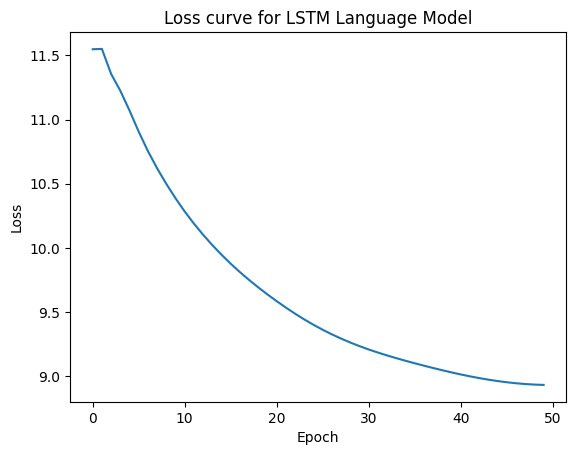

In [9]:
##### YOU ARE STRICTLY PROHIBITED FROM CHANGING THIS CELL !!!

np.random.seed(22) #don't change the seed

X_seq = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # Shape: (batch_size, seq_len, vocab_size)
# Initialize model
model = LSTMLM(vocab_size=8414, hidden_dim=100)
# Train the model
losses = model.fit(X_seq, y, epochs=50, lr=1e-4)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curve for LSTM Language Model")
plt.show()

Now that you've hopefully seen the model improving, we can extract its weight matrices (Wi for input embeddings and Wf for forget gate embeddings) to use as word embeddings.

We have the choice of using either the input embeddings `(Wi)` or the forget gate embeddings `(Wf)`, or we could do something more experimental and take the average of both to analyze the word relationships.

Character Relationships:
Frodo-Sam Similarity: 0.0505
Gandalf-White Similarity: -0.2116
Mordor-Frodo Similarity: 0.0405
Shire-Aragorn Similarity: -0.1578

Forget Gate Relationships:
Frodo-Sam Similarity (Forget Gate): -0.0445
Gandalf-White Similarity (Forget Gate): -0.0601
Mordor-Frodo Similarity (Forget Gate): -0.1463
Shire-Aragorn Similarity (Forget Gate): 0.0694


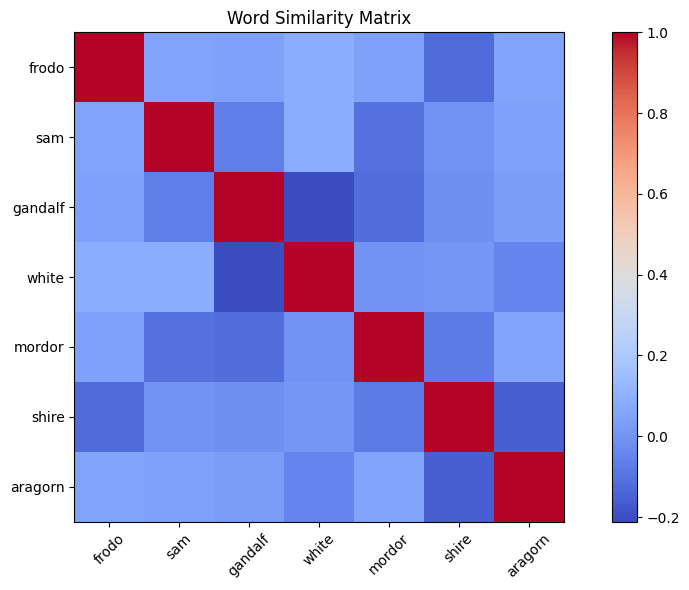

In [10]:
def cosine_similarity(v1, v2):
    # Compute cosine similarity between two vectors
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# For LSTM, we'll use the input embeddings (Wi) as our word embeddings
# We can also incorporate other matrices but Wi is most directly comparable to the original model's W1
embedding_matrix = model.W[0].T  # Using the input embeddings

# Compare character relationships
print("Character Relationships:")
print(f"Frodo-Sam Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['frodo']], embedding_matrix[dataset.stoi['sam']]):.4f}")
print(f"Gandalf-White Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['gandalf']], embedding_matrix[dataset.stoi['white']]):.4f}")
print(f"Mordor-Frodo Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['mordor']], embedding_matrix[dataset.stoi['frodo']]):.4f}")
print(f"Shire-Aragorn Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['shire']], embedding_matrix[dataset.stoi['aragorn']]):.4f}")

# You can also analyze the forget gate embeddings to see relationship patterns
forget_embeddings = model.W[1].T
print("\nForget Gate Relationships:")
print(f"Frodo-Sam Similarity (Forget Gate): {cosine_similarity(forget_embeddings[dataset.stoi['frodo']], forget_embeddings[dataset.stoi['sam']]):.4f}")
print(f"Gandalf-White Similarity (Forget Gate): {cosine_similarity(forget_embeddings[dataset.stoi['gandalf']], forget_embeddings[dataset.stoi['white']]):.4f}")
print(f"Mordor-Frodo Similarity (Forget Gate): {cosine_similarity(forget_embeddings[dataset.stoi['mordor']], forget_embeddings[dataset.stoi['frodo']]):.4f}")
print(f"Shire-Aragorn Similarity (Forget Gate): {cosine_similarity(forget_embeddings[dataset.stoi['shire']], forget_embeddings[dataset.stoi['aragorn']]):.4f}")

def plot_word_similarities(words, embedding_matrix):
    plt.figure(figsize=(10, 6))
    similarities = np.zeros((len(words), len(words)))
    
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            similarities[i, j] = cosine_similarity(
                embedding_matrix[dataset.stoi[word1]],
                embedding_matrix[dataset.stoi[word2]]
            )
    
    plt.imshow(similarities, cmap='coolwarm')
    plt.xticks(range(len(words)), words, rotation=45)
    plt.yticks(range(len(words)), words)
    plt.colorbar()
    plt.title("Word Similarity Matrix")
    plt.tight_layout()
    plt.show()

key_words = ['frodo', 'sam', 'gandalf', 'white', 'mordor', 'shire', 'aragorn']
plot_word_similarities(key_words, embedding_matrix)

Think about whether these performed better than the previous ones, and why.

**Question:**  Based on the cosine similarity results and the word similarity matrix visualization, which word pairs have the highest similarity, and what insights can we draw from this in terms of the model's understanding of word relationships?

**Answer:**  The highest similarity (even that is weak) is between ```Frodo & Sam```; it appears the model didn't capture their relationship well because the value should have been higher. 

The model should have given a positive score (high similarity) between ```Gandalf & White``` aka Gandalf the White, but it gave a negative score (dissimialrity) maybe thinking of 'Saruman the White'. The model gave a small +ve similarity between ```Mordor-Frodo```. Since Frodo’s journey revolves around destroying the Ring in Mordor, the similarity should have been higher. ```Shire and Aragorn``` are very different in context so a negative value makes sense.

**Forget Gate Embeddings:** ```Frodo and Sam``` have a slightly negative similarity, suggesting the model treats them somewhat independently. ```Gandalf and White``` are also weakly negative, likely distinguishing Gandalf from Saruman the White. However, ```Mordor and Frodo``` have a stronger negative similarity, which is unexpected given their connection in the story. ```Shire and Aragorn``` show a small positive similarity, implying the model retains information about one when encountering the other, despite their distinct contexts. These results suggest the model captures some weak relationships but may need refinement in distinguishing key character and location associations.

## Comparision with Word2Vec

### Now, since you are successfully implemented a LSTM model, lets reflect back to PA1.1, where you trained a word2vec model to learn the embeddings.

In this part load the learned embeddings from PA1.1 and plot a heatmap similar to the one plotted above. After plotting, make a comparision of the heatmaps between LSTM and word2vec

Character Relationships:
Frodo-Sam Similarity: 0.0726
Gandalf-White Similarity: -0.1487
Mordor-Frodo Similarity: -0.0918
Shire-Aragorn Similarity: -0.0842


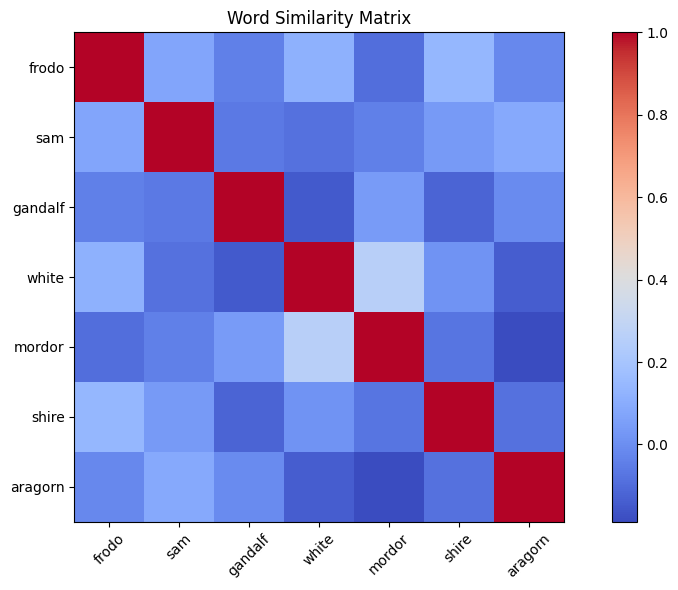

In [11]:
#Load embeddings in PA1.1
embedding_matrix = np.load('word2vec.npy').reshape(8451, 100)


# Compare character relationships
print("Character Relationships:")
print(f"Frodo-Sam Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['frodo']], embedding_matrix[dataset.stoi['sam']]):.4f}")
print(f"Gandalf-White Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['gandalf']], embedding_matrix[dataset.stoi['white']]):.4f}")
print(f"Mordor-Frodo Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['mordor']], embedding_matrix[dataset.stoi['frodo']]):.4f}")
print(f"Shire-Aragorn Similarity: {cosine_similarity(embedding_matrix[dataset.stoi['shire']], embedding_matrix[dataset.stoi['aragorn']]):.4f}")

# Visualization of embeddings (optional)
def plot_word_similarities(words, embedding_matrix):
    plt.figure(figsize=(10, 6))
    similarities = np.zeros((len(words), len(words)))

    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            similarities[i, j] = cosine_similarity(
                embedding_matrix[dataset.stoi[word1]],
                embedding_matrix[dataset.stoi[word2]]
            )

    plt.imshow(similarities, cmap='coolwarm')
    plt.xticks(range(len(words)), words, rotation=45)
    plt.yticks(range(len(words)), words)
    plt.colorbar()
    plt.title("Word Similarity Matrix")
    plt.tight_layout()
    plt.show()

# Plot similarities between key words
key_words = ['frodo', 'sam', 'gandalf', 'white', 'mordor', 'shire', 'aragorn']
plot_word_similarities(key_words, embedding_matrix)


Comment on the differences between the two heatmaps

**Answer:** The ```Frodo-Sam``` similarity is higher (0.0726 vs. 0.0505), suggesting Word2Vec sees a stronger connection between them. ```Gandalf-White``` remains negative but is closer to zero (-0.1487 vs. -0.2116), meaning Word2Vec distinguishes them less than the LSTM. The biggest difference is in the ```Mordor-Frodo``` relationship — Word2Vec assigns a negative similarity (-0.0918), while the LSTM's input gate had a slight positive similarity (0.0405). This suggests Word2Vec strongly differentiates them, whereas the LSTM might capture a more contextual dependency. Finally, ```Shire-Aragorn``` is negative in both models, but Word2Vec (-0.0842) is closer to zero than the LSTM (-0.1578), possibly indicating that Word2Vec does not separate them as distinctly. Word2Vec appears to capture more conventional word associations, while the LSTM embeddings may encode more contextual dependencies.

## Part 3 - Playing with Word Vectors [20 points]

The intensive parts of this assignment are over - now we'll play with pretrained embeddings, i.e. embeddings that someone else has trained.

We will use the GloVe embeddings from `gensim`, a Python library made for interacting with word vectors.

In the cells below, we will make our imports, load in our embeddings, and construct our numpy matrix.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import gensim.downloader as api
from pprint import pprint

def load_embedding_model():
    '''
    Loads the GloVe embeddings from gensim
    '''
    gensim_wv = api.load("glove-wiki-gigaword-200")
    print(f"Loaded embeddings with vocab size {len(gensim_wv.key_to_index)} with vector size {gensim_wv.vector_size}")
    return gensim_wv

In [13]:
# Load in the Embeddings (this can take ~8 minutes)
gensim_wv = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded embeddings with vocab size 400000 with vector size 200


In [14]:
def get_embedding_matrix(gensim_wv):
    
    # Get the words in the vocab
    words = list(gensim_wv.index_to_key)
    stoi = {}
    M = []
    curInd = 0
    
    # Add the words to the matrix M
    for w in words:
        try:
            M.append(gensim_wv.get_vector(w))
            stoi[w] = curInd
            curInd += 1
        except KeyError:
            continue
    
    # Convert the list of vectors to a numpy matrix
    M = np.stack(M)
    print("Done.")

    return M, stoi

M, stoi = get_embedding_matrix(gensim_wv)
print(f"Shape of the embedding matrix: {M.shape}")

Done.
Shape of the embedding matrix: (400000, 200)


### Visualizing our embeddings

Now that we've created our matrix, let's work on visualizing them.

The issue with these embeddings is that they are in 200 dimensions. Most humans can't see beyond 3 dimensions, and it's convenient to plot in 2.

One nifty trick we can do to _squish_ down a vector in higher dimensions, to something in fewer dimensions, is to utilize **Dimensionality Reduction** techniques. This will learn the ambient structure in the data, and use it to capture as much information (technically, the "variance") in the amount of dimensions you want.

Most people go with [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) or [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) for this. We will go with a variant of [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition), a method to factorize a matrix.

You can read up on the documentation for the `sklearn` implementation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In the cell below, implement the `reduce_to_k_dim` algorithm, where you run `TruncatedSVD` to squish your `(vocab_size, emb_dim)` matrix to `(vocab_size, K)`, where `K` is much smaller than `emb_dim`.

In [15]:
from sklearn.decomposition import TruncatedSVD

def reduce_to_k_dim(M, k=2):
    '''
    Reduce a matrix of shape (num_words, num_dim) to (num_words, k) dimensions
    '''
    n_iters = 10
    print(f"Running Truncated SVD over {n_iters} iterations...")

    svd = TruncatedSVD(n_components=k)
    M_reduced = svd.fit_transform(M)

    return M_reduced

# Reduce the matrix to 2 dimensions
M_reduced = reduce_to_k_dim(M, k=2)

# Normalize the rows to make them of unit length (helps with visualization)
M_reduced_unit = M_reduced / np.linalg.norm(M_reduced, axis=1, keepdims=True)

print(f"Shape of the reduced matrix: {M_reduced_unit.shape}")

Running Truncated SVD over 10 iterations...
Shape of the reduced matrix: (400000, 2)


In the cell below, you can plot out the embeddings from the reduced matrix. Note that since we squished the information coming from 200 dimensions into just 2, we won't have a perfect visualization by any means, but it's still worth studying.

In the cell below, you can fill `words_to_plot` with words whose embeddings you'd like to see in a scatterplot. If you wish to join pairs of words, you can pass them in as pairs in the `pairs_to_join` variable.

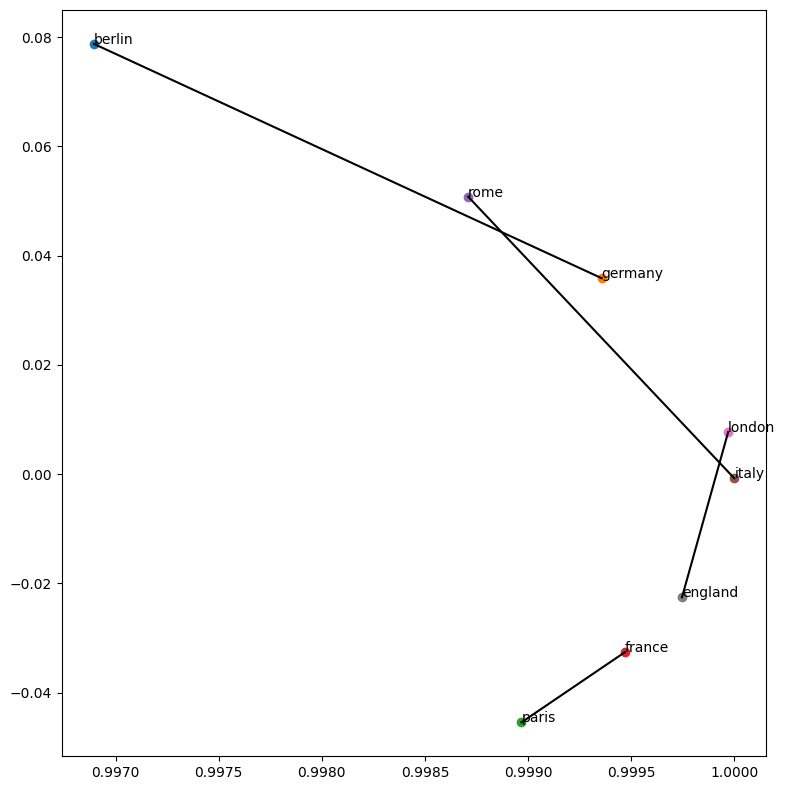

In [16]:
def plot_embeddings(M_reduced_unit, words, stoi, pairs_to_join):
    '''
    Produces a scatterplot of the embeddings with the words annotated

    Parameters:
    M_reduced_unit : np.ndarray
        The reduced matrix of embeddings
    words : List[str]
        The words to annotate
    '''
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, txt in enumerate(words):
        word_ind = stoi.get(txt)
        ax.scatter(M_reduced_unit[word_ind, 0], M_reduced_unit[word_ind, 1])
        ax.annotate(txt, (M_reduced_unit[word_ind, 0], M_reduced_unit[word_ind, 1]))

    for pair in pairs_to_join:
        w1, w2 = pair
        w1_ind = stoi.get(w1)
        w2_ind = stoi.get(w2)
        ax.plot([M_reduced_unit[w1_ind, 0], M_reduced_unit[w2_ind, 0]], 
                [M_reduced_unit[w1_ind, 1], M_reduced_unit[w2_ind, 1]], 'k-')

    plt.tight_layout()
    plt.show()

words_to_plot = ["berlin", "germany", "paris", "france", "rome", "italy", "london", "england"]
pairs_to_join = [("berlin", "germany"), ("paris", "france"), ("rome", "italy"), ("london", "england")]
plot_embeddings(M_reduced_unit, words_to_plot, stoi, pairs_to_join)

### Analogies with Word Vectors

Recall from the lectures that word vectors let us capture relationships between words. This means we can use vector arithmetic to create _analogies_.

For example, if we had an embedding matrix E, and we wanted to find the relationship between `king` and `man`, and `queen` and `woman`, we would find

$$E[\text{king}] - E[\text{man}] \approx E[\text{queen}] - E[\text{woman}]$$

`gensim` makes this really easy for us. To save time, we can use the `most_similar` function to capture the nearest neighbors to the vector you get when "constructing the parallelogram" (from lecture).

In [17]:
# "king is to man, as ??? is to woman"
gensim_wv.most_similar(
    positive=['woman', 'king'],
    negative=['man']
)

[('queen', 0.6978678703308105),
 ('princess', 0.6081743836402893),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168542861938477),
 ('crown', 0.5164473056793213)]

These are not perfect by any means. Run the cell below to see one case of the arithmetic failing.

Write a few words about why this might be the case - there's a very reasonable explanation, provided you don't use the metric system ;)

In [18]:
# "glove is to hand as ??? is to foot"
gensim_wv.most_similar(
    positive=['foot', 'glove'],
    negative=['hand']
)

[('45,000-square', 0.4922032058238983),
 ('15,000-square', 0.4649604260921478),
 ('10,000-square', 0.45447564125061035),
 ('6,000-square', 0.44975781440734863),
 ('3,500-square', 0.4441334903240204),
 ('700-square', 0.442575067281723),
 ('50,000-square', 0.4356396794319153),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.43305960297584534),
 ('footed', 0.43236881494522095)]

**Answer** It looks like the model associates the word ```foot``` more with the measurement units than with the part of animal body.

Lastly, it's important to know that biases and stigmas are implicit inside these word embeddings. 

Run the cell below, to examine (a) which terms are most similar to "woman" and "profession" and most dissimilar to "man", and (b) which terms are most similar to "man" and "profession" and most dissimilar to "woman". 

Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [20]:
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint(gensim_wv.most_similar(positive=['man', 'profession'], negative=['woman']))
print('-'*25)
pprint(gensim_wv.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176191329956),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046963453292847),
 ('skills', 0.4900550842285156),
 ('ethic', 0.48976603150367737),
 ('business', 0.4875852167606354),
 ('respected', 0.4859202802181244),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572916984558),
 ('life', 0.4760662317276001)]
-------------------------
[('professions', 0.5957456231117249),
 ('practitioner', 0.4988412857055664),
 ('teaching', 0.48292145133018494),
 ('nursing', 0.48211798071861267),
 ('vocation', 0.4788966476917267),
 ('teacher', 0.4716033935546875),
 ('practicing', 0.46937811374664307),
 ('educator', 0.46524307131767273),
 ('physicians', 0.4628995954990387),
 ('professionals', 0.4601394832134247)]


**Answer:** When "man" is associated with "profession," the top related words include "reputation," "skill," "business," "respected," and "ethic" — all of which display competence, success, and status in professional life.

When "woman" is associated with "profession," the top words include "teaching," "nursing," "educator," and "vocation" — indicating a stronger association with caregiving and service-oriented roles.

# Fin.